# 1. Import and Install Dependencies

In [82]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib arabic_reshaper python-bidi

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [45]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import arabic_reshaper
from bidi.algorithm import get_display

# 2. Keypoints using MP Holistic

In [46]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [47]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [48]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [49]:
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:  
    image = cv2.imread("Data/train/0001/01_01_0001_(08_12_16_15_35_44)_c/01_01_0001_(08_12_16_15_35_44)_c_0001.jpg")
    image, results = mediapipe_detection(image, holistic)
                
    # # Draw landmarks
    # draw_styled_landmarks(image, results)
    # cv2.imshow('Image', image)
    # cv2.waitKey(0)
    

    # Make detections
    image, results = mediapipe_detection(image, holistic)
                
    # Draw landmarks
    draw_styled_landmarks(image, results)

    # Show image
    cv2.imshow('Image', image)
    cv2.waitKey(0)

# cv2.destroyAllWindows()

In [50]:
draw_styled_landmarks(image, results)

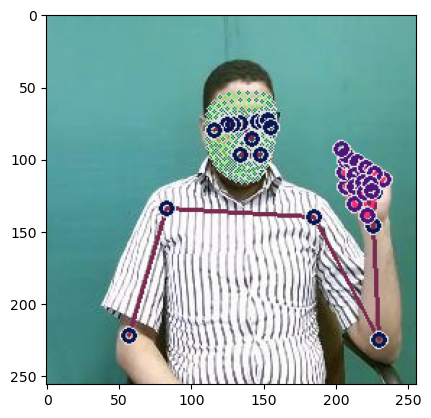

In [51]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [52]:
len(results.left_hand_landmarks.landmark)

21

In [56]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [57]:
result_test = extract_keypoints(results)

In [58]:
result_test

array([ 0.55616063,  0.33616301, -0.5366388 , ...,  0.        ,
        0.        ,  0.        ])

# 5. Collect Keypoint Values for Training

In [ ]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    dataset_path = 'Data/train'  # Path to the dataset folder
    datanp_path = 'Datanp/train'
    categories = os.listdir(dataset_path)  # Get the list of categories (subfolders)
    for category in categories:
        category_path = os.path.join(dataset_path, category)  # Path to the category folder
        subs = os.listdir(category_path)  # Get the list of subfolders within the category

        for sub in subs:
            subfolder_path = os.path.join(category_path, sub)  # Path to the subfolder
            image_files = os.listdir(subfolder_path)  # Get the list of image files in the subfolder

            for counter, image_file in enumerate(image_files):
                image_path = os.path.join(subfolder_path, image_file)  # Path to the image file
                print(image_path)
                image = cv2.imread(image_path)

                # Make detections
                image, results = mediapipe_detection(image, holistic)
                keypoints = extract_keypoints(results)

                npy_dir = os.path.join(datanp_path, category,sub)
                os.makedirs(npy_dir, exist_ok=True)  # Create the directory hierarchy if it doesn't exist

                npy_path = os.path.join(npy_dir,str(counter))
                np.save(npy_path, keypoints)

# 6. Collect Keypoint Values for Testing

In [ ]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    dataset_path = 'Data/test'  # Path to the dataset folder
    datanp_path = 'Datanp/test'
    categories = os.listdir(dataset_path)  # Get the list of categories (subfolders)
    for category in categories:
        category_path = os.path.join(dataset_path, category)  # Path to the category folder
        subs = os.listdir(category_path)  # Get the list of subfolders within the category

        for sub in subs:
            subfolder_path = os.path.join(category_path, sub)  # Path to the subfolder
            image_files = os.listdir(subfolder_path)  # Get the list of image files in the subfolder

            for counter,image_file in enumerate(image_files):
                image_path = os.path.join(subfolder_path, image_file)  # Path to the image file
                print(image_path)
                image = cv2.imread(image_path)

                # Make detections
                image, results = mediapipe_detection(image, holistic)
                keypoints = extract_keypoints(results)

                npy_dir = os.path.join(datanp_path, category,sub)
                os.makedirs(npy_dir, exist_ok=True)  # Create the directory hierarchy if it doesn't exist

                npy_path = os.path.join(npy_dir,str(counter))
                np.save(npy_path, keypoints)

# 7. Average Keypoints Approach

In [18]:
datanp_path= 'Datanp/train'
def extract_average_keypoints_from_folder(folder_path):
    all_keypoints = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.npy'):
            keypoints = np.load(os.path.join(folder_path, filename))
            all_keypoints.append(keypoints)
    if all_keypoints:
        return np.mean(all_keypoints, axis=0)
    else:
        return None

# Process keypoints for each video folder
categories = os.listdir(datanp_path)  # Get the list of categories (subfolders)
for category in categories:
    category_path = os.path.join(datanp_path, category)  # Path to the category folder
    subs = os.listdir(category_path)  # Get the list of subfolders (video folders) within the category

    for sub in subs:
        subfolder_path = os.path.join(category_path, sub)  # Path to the video folder
        avg_keypoints = extract_average_keypoints_from_folder(subfolder_path)
        
        if avg_keypoints is not None:
            npy_dir = os.path.join(datanp_path, category, sub)
            npy_path = os.path.join(npy_dir, 'avg_keypoints.npy')
            np.save(npy_path, avg_keypoints)

# 8.Importing Dataset into Model for Training

In [59]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load average keypoints and corresponding labels
def load_data(data_dir):
    X = []
    y = []
    categories = os.listdir(data_dir)
    for category in categories:
        category_path = os.path.join(data_dir, category)
        videos = os.listdir(category_path)
        for video in videos:
            keypoints_path = os.path.join(category_path, video, 'avg_keypoints.npy')
            if os.path.exists(keypoints_path):
                keypoints = np.load(keypoints_path)
                X.append(keypoints)
                y.append(int(category)-1)
    return np.array(X), np.array(y)

# Prepare data
data_dir = 'Datanp/train'
X, y = load_data(data_dir)
num_classes = len(set(y))  # Number of unique classes
print("Number of classes:", num_classes)
print("Unique labels:", np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input data to add a time dimension
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

Number of classes: 12
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [60]:
# Define LSTM model
model = Sequential([
    LSTM(units=128, input_shape=(1, X_train.shape[2])),
    Dense(units=64, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

In [61]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
# Train model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/200
13/13 [==============================] - 2s 44ms/step - loss: 2.4857 - accuracy: 0.0916 - val_loss: 2.4587 - val_accuracy: 0.1176
Epoch 2/200
13/13 [==============================] - 0s 13ms/step - loss: 2.4181 - accuracy: 0.1411 - val_loss: 2.3934 - val_accuracy: 0.1275
Epoch 3/200
13/13 [==============================] - 0s 13ms/step - loss: 2.3148 - accuracy: 0.2178 - val_loss: 2.3058 - val_accuracy: 0.2549
Epoch 4/200
13/13 [==============================] - 0s 12ms/step - loss: 2.1872 - accuracy: 0.2946 - val_loss: 2.1432 - val_accuracy: 0.2451
Epoch 5/200
13/13 [==============================] - 0s 13ms/step - loss: 2.0716 - accuracy: 0.2797 - val_loss: 2.1426 - val_accuracy: 0.2353
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 1.9793 - accuracy: 0.3144 - val_loss: 1.9824 - val_accuracy: 0.2745
Epoch 7/200
13/13 [==============================] - 0s 12ms/step - loss: 1.8866 - accuracy: 0.3119 - val_loss: 1.9068 - val_accuracy: 0.2353
Epoch 

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               916992    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 12)                780       
                                                                 
Total params: 926028 (3.53 MB)
Trainable params: 926028 (3.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 6. Labels From CSV

In [64]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [65]:
import pandas as pd
df = pd.read_csv("KARSL-190_Labels.csv")

In [66]:
sign_dict = {}

for i in range(0, 12):  # Loop from index 1 to 10 (inclusive)
    sign_id = df.loc[i, "SignID"] -1
    sign_arabic = df.loc[i, "Sign-Arabic"]
    sign_dict[sign_id] = sign_arabic

print(sign_dict)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '20'}


# 8. Make Predictions

In [67]:
res = model.predict(X_test)

4/4 [==============================] - 1s 2ms/step


In [68]:
y_test

array([ 4,  6, 11,  1, 10,  1,  7,  3, 11, 11,  4,  0,  9,  1,  7, 11,  2,
        9,  4, 10,  6,  6,  0, 11,  9, 11,  1, 10,  4, 11,  4,  7,  8,  8,
       11,  3,  0,  7,  4,  1, 11,  7,  4,  1,  2,  9,  0,  1, 11,  0,  0,
        6,  0,  2,  6, 11, 10,  6,  1,  5,  1,  1,  4,  0,  8,  4,  9,  1,
        0, 10,  1, 11, 10,  8,  1,  9,  2,  4,  9, 11,  1,  9,  6,  9,  7,
        4, 10,  7,  2,  3,  4,  9,  3,  8,  8,  3,  8,  9, 10,  9,  2,  1])

In [69]:
np.argmax(res[70])

1

In [70]:
y_test[70]

1

# 9. Save Weights

In [59]:
model.save('initial1.keras')

In [18]:
model.load_weights('initial1.keras')

# 10. Evaluation using Confusion Matrix and Accuracy

In [39]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [40]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 32ms/step


In [41]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [42]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[ 9,  0],
        [ 0,  2]],

       [[10,  0],
        [ 0,  1]],

       [[10,  0],
        [ 0,  1]],

       [[ 9,  0],
        [ 1,  1]],

       [[ 8,  2],
        [ 0,  1]],

       [[ 9,  0],
        [ 1,  1]],

       [[ 9,  0],
        [ 0,  2]]], dtype=int64)

In [43]:
accuracy_score(ytrue, yhat)

0.8181818181818182

# 11. Test in Real Time

In [60]:
from scipy import stats

In [63]:
colors = [(245,117,16), (117,245,16), (16,117,245),(255, 0, 0),(0, 255, 0),(0, 0, 255),(255, 255, 0)]
def prob_viz(res, sign_dict, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, sign_dict[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
import numpy as np

# New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            # Calculate average keypoints
            avg_keypoints = np.mean(sequence, axis=0)
            # Reshape to match model's input shape
            avg_keypoints = np.expand_dims(avg_keypoints, axis=0)
            avg_keypoints = np.expand_dims(avg_keypoints, axis=0)
            
            # Make prediction
            res = model.predict(avg_keypoints)[0]
            print(sign_dict[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
